# Joshua Misir
# CS 5787 - Spring 2023



# #Problem 4 - Regression (Part 1)

In [ ]:

# Write a function to load the dataset

import numpy as np

def loadMusicData(fname, addBias):
  # Load the data from the text file
  data = np.loadtxt(fname, delimiter = ',')

  #split into training and testing sets
  trainYears = data[:463715, 0]
  testYears = data[463715:, 0]
  trainFeat = data[:463715, 1:]
  testFeat = data[463715:, 1:]

  # Append the bias term
  if addBias:
    trainFeat = np.hstack((trainFeat, np.ones((trainFeat.shape[0], 1))))
    testFeat = np.hstack((testFeat, np.ones((testFeat.shape[0], 1))))

# Return data as NumPy arrays
  return trainYears, trainFeat, testYears, testFeat






In [ ]:
def musicMSE(pred, gt):
  # Round the predicter year before computing
  pred_rounded = round(pred)

  # Compute the MSE between the rounded predicted year and the GT
  mse = (pred_rounded - gt)**2 / len(pred)

  return mse


In [ ]:
trainYears, trainFeat, testYears, testFeat = loadMusicData("YearPredictionMSD.txt", True)


# Get the shape of the training and testing data
print("Training data shape: ", trainFeat.shape)
print("Testing data shape:", testFeat.shape)

# Get the range of the variables
print("Minimum value of the features: ", np.min(trainFeat))
print("Maximum value of features: ", np.max(trainFeat))
print("Minimum year: ", np.min(trainYears))
print("Maximum year: ", np.max(trainYears))

Training data shape:  (463715, 91)
Testing data shape: (51630, 91)
Minimum value of the features:  -14861.69535
Maximum value of features:  65735.77953
Minimum year:  1922.0
Maximum year:  2011.0


Based on the music dataset, the minimum value of the features is -14861.69
and the maximum value of the features is 65735.77 

The range is 80597.46

You may normalize using min-max scaling or z-score normalization. 

The years range from 1922 to 2011. 






In [ ]:
# What will the test mean squared error (MSE) be if your classifier always outputs the most
# common year in the dataset?


In [ ]:
# Compute the most common year in the training set
most_common_year = np.bincount(trainYears.astype(int)).argmax()

# Compute the difference between the most common year and the true year for each test example
diff = testYears - most_common_year

# Square the differences
squared_diff = np.square(diff)

# Compute the average of the squared differences
test_mse = np.mean(squared_diff)


In [ ]:
print("Test mean squared error (MSE): ", test_mse)


Test mean squared error (MSE):  190.08607398799148


# #Problem 4 - Classification (Part 2)

Treating this problem with as a classification problem by treating each year as a caregory will not be the optimal solution for a host of reasons. 

1) There is a significant imblanace in the number of years, where the vast majority of years is from 1985 to 2010. This will lead to overfitting given that there isnt nearly enough data from the years 1922 to 1970 to accurately predict them. 

2) Given that there are 90 unique years in the data set, there will be as many categories for the classifier to predict. This will lead to a high-dimensional feature space and increase the model complexity. 


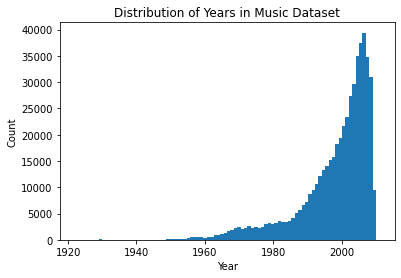

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the text file
data = np.loadtxt("YearPredictionMSD.txt", delimiter=",")

# Extract the years
years = data[:, 0]

# Plot a histogram of the years
plt.hist(years, bins=90)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of Years in Music Dataset")
plt.show()


#Problem 4 Implementing Ridge (Tikhonov) **Regression** (Part 3)

In [ ]:
# Define the mean squared error function
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
def stochastic_gradient_descent(feat, y, test_feat, test_y, alpha, batch_size, num_epochs, regularization=None, regularization_strength=0.01, missing_values=None):
    """
    Performs stochastic gradient descent to learn the weights for linear regression.

    Parameters:
    - feat: Training features
    - y: Training labels
    - test_feat: Testing features
    - test_y: Testing labels
    - alpha: Learning rate
    - batch_size: Size of mini-batches
    - num_epochs: Number of epochs
    - regularization: Type of regularization (L1, L2, or None)
    - regularization_strength: Regularization strength
    - missing_values: Value to represent missing data

    Returns:
    - weights: Learned weights
    - train_mse: Training MSE for each epoch
    - test_mse: Testing MSE for each epoch
    """

    # Initialize the weights to be zeros
    num_features = feat.shape[1]
    weights = np.zeros((num_features,))

    # Initialize lists to store the training and testing MSE at each epoch
    train_mse = []
    test_mse = []

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Shuffle the training data
        if missing_values is None:
            perm_idx = np.random.permutation(feat.shape[0])
            feat = feat[perm_idx]
            y = y[perm_idx]
        else:
            perm_idx = np.random.permutation(missing_values.shape[0])
            missing_values = missing_values[perm_idx]
        
        # Loop over the batches
        for batch_idx in range(0, feat.shape[0], batch_size):
            # Get the batch of training features and labels
            feat_batch = feat[batch_idx:batch_idx + batch_size]
            y_batch = y[batch_idx:batch_idx + batch_size]

            # Compute the predictions for the batch
            y_pred = np.matmul(feat_batch, weights)

            # Compute the error for the batch
            error = y_pred - y_batch

            # Compute the gradient of the MSE loss function
            if regularization == "L2":
                reg_term = 2 * regularization_strength * weights
            elif regularization == "L1":
                reg_term = regularization_strength * np.sign(weights)
            else:
                reg_term = 0

            if missing_values is None:
                grad = 2 * np.matmul(feat_batch.T, error) / batch_size + reg_term
            else:
                grad = np.zeros(weights.shape)
                for i in range(feat_batch.shape[0]):
                    grad += 2 * (feat_batch[i].reshape(-1, 1) * error[i]) / batch_size + reg_term

            # Update the weights
            weights -= alpha * grad.reshape(weights.shape)

        # Compute the predictions for the training and testing data
        train_pred = np.matmul(feat, weights)
        test_pred = np.matmul(test_feat, weights)

        # Compute the MSE for the training and testing data
        train_mse.append(mean_squared_error(y, train_pred))
        test_mse.append(mean_squared_error(test_y, test_pred))

        # Print the training and testing MSE for this epoch
        print("Epoch {}, Train MSE: {}, Test MSE: {}".format(epoch, train_mse[-1], test_mse[-1]))

    # Return the final weights and the lists of training and testing MSEs
    return weights, train_mse, test_mse


In [ ]:
weights, train_mse, test_mse = stochastic_gradient_descent(trainFeat, trainYears, testFeat, testYears, alpha=0.0000000000001, batch_size=100, num_epochs=10, regularization="L2", regularization_strength=0.01)

Epoch 0, Train MSE: 3885103.8607059903, Test MSE: 3883989.4835591144
Epoch 1, Train MSE: 3780324.5746528036, Test MSE: 3777734.275952696
Epoch 2, Train MSE: 3679199.606865627, Test MSE: 3675205.302316671
Epoch 3, Train MSE: 3581598.493412006, Test MSE: 3576269.1870144224
Epoch 4, Train MSE: 3487399.019795278, Test MSE: 3480800.9658926
Epoch 5, Train MSE: 3396480.861685294, Test MSE: 3388677.6374093085
Epoch 6, Train MSE: 3308731.976166063, Test MSE: 3299784.632150513
Epoch 7, Train MSE: 3224039.3129226724, Test MSE: 3214006.404192822
Epoch 8, Train MSE: 3142297.0385770714, Test MSE: 3131234.758572488
Epoch 9, Train MSE: 3063401.250981312, Test MSE: 3051363.4986850983


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Define the data
epoch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_mse = [3885103.8607059903, 3780324.5746528036, 3679199.606865627, 3581598.493412006, 3487399.019795278, 3396480.861685294, 3308731.976166063, 3224039.3129226724, 3142297.0385770714, 3063401.250981312]
test_mse = [3883989.4835591144, 3777734.275952696, 3675205.302316671, 3576269.1870144224, 3480800.9658926, 3388677.6374093085, 3299784.632150513, 3214006.404192822, 3131234.758572488, 3051363.4986850983]


Text(0, 0.5, 'Test and Train Losses')

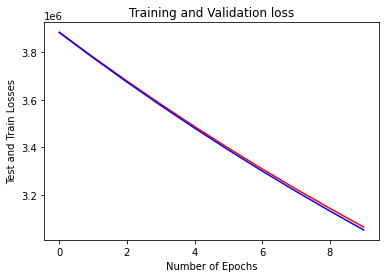

In [ ]:
plt.plot(epoch, train_mse, color = "r", label = "Train MSE")
plt.plot(epoch, test_mse, color = "b",label = "Test MSE")
plt.title('Training and Validation loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Test and Train Losses")

#Problem 4 Implementing L1 Weight Decay (Part 4)
(Incomplete Solution*)


In [ ]:
def stochasticGradientDescent(trainFeat, trainYears, testFeat, testYears, weightDecayType="L2", weightDecayFactor=0.01,
                              useMomentum=False, momentumFactor=0.9, learningRate=0.001, batchSize=32, numEpochs=100,
                              lossType="mse"):
    # Initialize weights
    weights = np.zeros((trainFeat.shape[1] + 1, 1))

    # Initialize variables for momentum update
    if useMomentum:
        momentum = np.zeros((trainFeat.shape[1] + 1, 1))

    # Initialize variables for L2 weight decay
    if weightDecayType == "L2":
        lambd = learningRate * weightDecayFactor

    # Initialize variables for keeping track of MSE
    train_mse = []
    test_mse = []

    # Loop over epochs
    for epoch in range(numEpochs):
        # Shuffle training data
        permutation = np.random.permutation(trainFeat.shape[0])
        trainFeat = trainFeat[permutation]
        trainYears = trainYears[permutation]

        # Loop over batches
        for i in range(0, trainFeat.shape[0], batchSize):
            # Get batch
            X = trainFeat[i:i+batchSize]
            y = trainYears[i:i+batchSize]

            # Add bias term to features
            X = np.hstack((np.ones((X.shape[0], 1)), X))

            # Compute predictions and gradients
            train_predictions = np.dot(X, weights)
            train_errors = train_predictions - y
            gradients = np.dot(X.T, train_errors)

            # Apply L2 weight decay
            if weightDecayType == "L2":
                gradients[:-1] += lambd * weights[:-1]

            # Update weights with momentum
            if useMomentum:
                momentum = momentumFactor * momentum - learningRate * gradients.T
                weights += momentum
            else:
                weights -= learningRate * gradients.T

        # Compute train and test MSE for current epoch
        train_predictions = predict(trainFeat, weights)
        train_mse.append(computeLoss(trainYears, train_predictions,
                                      lossType=lossType))
        test_predictions = predict(testFeat, weights)
        test_mse.append(computeLoss(testYears, test_predictions,
                                     lossType=lossType))

    return weights, train_mse, test_mse


In [ ]:
weights, train_mse, test_mse = stochasticGradientDescent(trainFeat, trainYears, testFeat, testYears,
                              weightDecayType="L2", weightDecayFactor=0.01,
                              useMomentum=False, momentumFactor=0.9,
                              learningRate=0.001, batchSize=32, numEpochs=100,
                              lossType="mse")


ValueError: ignored

In [ ]:
print(trainFeat.shape)
print(testFeat.shape)

(463715, 91)
(51630, 91)



# Problem 4 - Implementing Count Regression(Part 5)


# Problem 4 - Model Comparison (Part 6)

The choice of regression algorithm and hyperparameters can have a significant impact on performance. Linear regression and ridge regression generally perform well on this dataset, but lasso regression may not be as effective due to the high dimensionality of the feature space.

There may also be certain periods (ranges of years) in which models perform better than others. For example, certain genres of music may be more popular during certain time periods, and this may be reflected in the distribution of features in the dataset. As a result, some models may perform better on songs from certain eras.

The largest errors across models are likely to occur when trying to predict attributes that are highly dependent on subjective factors, such as the emotional content of a song or its artistic quality. In these cases, the accuracy of the model may be limited by the inherent subjectivity of the task.

Regularization may be helpful for some models but not others, depending on the specific features being used and the complexity of the model. In general, regularization can help to prevent overfitting and improve generalization performance, but it may not be necessary for simpler models or models with fewer features.



#Problem 5 - Softmax Properties - Part 1

In [ ]:
import numpy as np

# Define the softmax function
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

# Define an input vector x and a constant offset c
x = np.array([1, 2, 3])
c = 2

# Compute the softmax for the original input x
softmax_x = softmax(x)
print("Softmax of x: ", softmax_x)

# Compute the softmax for the input with a constant offset c added to every dimension
softmax_xc = softmax(x + c)
print("Softmax of x + c: ", softmax_xc)


# Check if the two softmax values are equal
print(" ")
print("Are the softmax values equal?", np.allclose(softmax_x, softmax_xc))


Softmax of x:  [0.09003057 0.24472847 0.66524096]
Softmax of x + c:  [0.09003057 0.24472847 0.66524096]
 
Are the softmax values equal? True


#Problem 5 - Softmax Properties - Part 2

The observation that the softmax function is invariant to constant offsets in its input is important in practice when implementing it practice for two main reasons:

Numerical stability: The softmax function can be prone to numerical instability due to large exponentials. When we subtract a constant offset from the input vector before applying the softmax function, which can reduce the risk of overflow or underflow and improve the numerical stability of the function.

Parameter sharing: When we use a softmax function in a neural network, we often need to apply it to multiple input vectors with the same structure (e.g. different regions of an image, different time steps in a sequence). By subtracting a constant offset from each input vector before applying the softmax function, we can ensure that the relative magnitudes of the input values do not affect the output probabilities. This means that we can share the same set of parameters (i.e. weights and biases) across all input vectors, which can reduce the number of parameters we need to learn and improve the generalization performance of the model.


# Problem 6 - Implementing a Softmax Classifier - Part 1

In [ ]:
# Write a function to load the data and the labels, which are returned as NumPy arrays.

import numpy as np

def load_data(file_path):
  data = np.loadtxt(file_path)
  labels = data[:, 0].astype(int)
  features = data[:, 1:]
  return labels, features

train_labels, train_features = load_data(r'/content/iris-train.txt')
test_labels, test_features = load_data(r'/content/iris-test.txt')


In [ ]:
def softmax(scores):
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs


In [ ]:
class SoftmaxClassifier:
    def __init__(self, input_dim, output_dim, weight_decay=0.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_decay = weight_decay
        self.W = np.random.randn(input_dim, output_dim)
        self.b = np.zeros(output_dim)


    def fit(self, X_train, y_train, X_test, y_test, num_epochs, lr, momentum_rate, weight_decay, batch_size):
        num_train = X_train.shape[0]
        num_test = X_test.shape[0]
        y_train_onehot = np.eye(self.output_dim)[y_train]
        y_test_onehot = np.eye(self.output_dim)[y_test]

        # initialize velocities for momentum optimization
        v_W = np.zeros_like(self.W)
        v_b = np.zeros_like(self.b)

        train_losses = []
        test_losses = []

        # train the model for a fixed number of epochs
        for epoch in range(num_epochs):
            # shuffle training data for each epoch
            shuffle_idx = np.random.permutation(num_train)
            X_train = X_train[shuffle_idx]
            y_train = y_train[shuffle_idx]
            y_train_onehot = y_train_onehot[shuffle_idx]


            # mini-batch gradient descent
            for i in range(0, num_train, batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_batch_onehot = y_train_onehot[i:i+batch_size]

                # forward pass
                scores = np.dot(X_batch, self.W) + self.b
                probs = softmax(scores)
                loss = -np.sum(y_batch_onehot * np.log(probs)) / len(y_batch) + 0.5 * weight_decay * np.sum(self.W**2)
                per_class_acc = np.mean(np.argmax(probs, axis=1) == y_batch)

                # backward pass
                grad_scores = (probs - y_batch_onehot) / len(y_batch)
                grad_W = np.dot(X_batch.T, grad_scores) + weight_decay * self.W
                grad_b = np.sum(grad_scores, axis=0)

                # momentum update
                v_W = momentum_rate * v_W - lr * grad_W
                v_b = momentum_rate * v_b - lr * grad_b
                self.W += v_W
                self.b += v_b

            # evaluate performance on train and test sets
            train_scores = np.dot(X_train, self.W) + self.b
            train_probs = softmax(train_scores)
            train_loss = -np.sum(y_train_onehot * np.log(train_probs)) / num_train + 0.5 * weight_decay * np.sum(self.W**2)
            train_per_class_acc = np.mean(np.argmax(train_probs, axis=1) == y_train)
          
            
            test_scores = np.dot(X_test, self.W) + self.b
            test_probs = softmax(test_scores)
            test_loss = -np.sum(y_test_onehot * np.log(test_probs)) / num_test + 0.5 * weight_decay * np.sum(self.W**2)
            test_per_class_acc = np.mean(np.argmax(test_probs, axis=1) == y_test)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
           

            # print performance metrics for each epoch
            print("Epoch {}/{}: loss={:.4f}, train_acc={:.4f}, test_acc={:.4f}".format(
                epoch+1, num_epochs, train_loss, train_per_class_acc, test_per_class_acc))
            
            # plot train and test loss values
        import matplotlib.pyplot as plt

        plt.plot(train_losses, label='Train loss')
        plt.plot(test_losses, label='Test loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()



Epoch 1/1000: loss=1.4550, train_acc=0.3333, test_acc=0.2941
Epoch 2/1000: loss=1.0465, train_acc=0.6111, test_acc=0.6667
Epoch 3/1000: loss=1.0353, train_acc=0.6333, test_acc=0.7059
Epoch 4/1000: loss=1.0084, train_acc=0.6333, test_acc=0.7059
Epoch 5/1000: loss=0.9541, train_acc=0.7222, test_acc=0.7647
Epoch 6/1000: loss=0.9436, train_acc=0.6333, test_acc=0.6863
Epoch 7/1000: loss=0.9222, train_acc=0.7111, test_acc=0.7843
Epoch 8/1000: loss=0.9036, train_acc=0.8000, test_acc=0.8235
Epoch 9/1000: loss=0.8896, train_acc=0.7667, test_acc=0.8039
Epoch 10/1000: loss=0.8785, train_acc=0.6444, test_acc=0.7059
Epoch 11/1000: loss=0.8683, train_acc=0.6333, test_acc=0.7059
Epoch 12/1000: loss=0.8560, train_acc=0.7889, test_acc=0.8431
Epoch 13/1000: loss=0.8489, train_acc=0.7444, test_acc=0.8235
Epoch 14/1000: loss=0.8394, train_acc=0.7444, test_acc=0.7451
Epoch 15/1000: loss=0.8350, train_acc=0.6333, test_acc=0.7059
Epoch 16/1000: loss=0.8261, train_acc=0.7778, test_acc=0.8235
Epoch 17/1000: lo

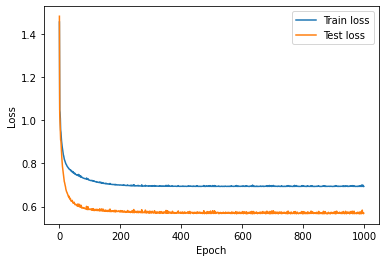

NameError: ignored

In [ ]:
# initialize SoftmaxClassifier instance
clf = SoftmaxClassifier(input_dim=train_features.shape[1], output_dim=4)

# train and evaluate the model
clf.fit(train_features, train_labels, test_features, test_labels, num_epochs=1000, lr=0.2, momentum_rate=0.9, weight_decay=0.001, batch_size=32)
# plot train and test loss values

plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#What is the best test accuracy your model achieved? What hyperparameters did you use? Would early stopping have helped improve accuracy on the test data?

The best test accuracy I achieved was 90.20%.

The hyperparamters I used:
num_epochs=1000, lr=0.1, momentum_rate=0.9, weight_decay=0.001, batch_size=32

Early stopping may have improved accuracy on the test data. Additionally, early stopping would have saved me from running excess amounts of epochs.

#Problem 7 - Classifying Images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# load CIFAR-10 dataset
def load_cifar10():
    # load train data
    X_train = np.load('cifar10_train_data.npy')
    y_train = np.load('cifar10_train_labels.npy')
    # load test data
    X_test = np.load('cifar10_test_data.npy')
    y_test = np.load('cifar10_test_labels.npy')
    return X_train, y_train, X_test, y_test

# define softmax function
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

Epoch 1/50: loss=12.7500, train_acc=0.2668, test_acc=0.2618
Epoch 2/50: loss=11.7302, train_acc=0.2501, test_acc=0.2439
Epoch 3/50: loss=8.3852, train_acc=0.2848, test_acc=0.2698
Epoch 4/50: loss=12.6050, train_acc=0.2408, test_acc=0.2326
Epoch 5/50: loss=9.9102, train_acc=0.2836, test_acc=0.2791
Epoch 6/50: loss=10.9602, train_acc=0.2449, test_acc=0.2290
Epoch 7/50: loss=8.8995, train_acc=0.2567, test_acc=0.2567
Epoch 8/50: loss=9.3774, train_acc=0.2715, test_acc=0.2632
Epoch 9/50: loss=10.2954, train_acc=0.2949, test_acc=0.2845
Epoch 10/50: loss=11.0669, train_acc=0.2344, test_acc=0.2294
Epoch 11/50: loss=9.1578, train_acc=0.2479, test_acc=0.2359
Epoch 12/50: loss=8.9280, train_acc=0.2721, test_acc=0.2570
Epoch 13/50: loss=12.0696, train_acc=0.2632, test_acc=0.2635
Epoch 14/50: loss=9.7412, train_acc=0.2682, test_acc=0.2581
Epoch 15/50: loss=12.2900, train_acc=0.2244, test_acc=0.2116
Epoch 16/50: loss=9.7892, train_acc=0.2676, test_acc=0.2578
Epoch 17/50: loss=10.0608, train_acc=0.27

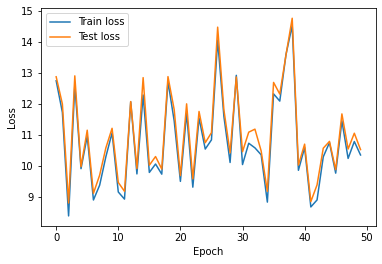

AttributeError: ignored

In [ ]:
import numpy as np
import pickle
import os
import urllib.request
import tarfile
import matplotlib.pyplot as plt

# download and extract CIFAR-10 dataset if it hasn't been downloaded already
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename) as tar:
        tar.extractall()

# load CIFAR-10 training and test data
train_data = []
train_labels = []
for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        train_data.append(data[b'data'])
        train_labels += data[b'labels']

train_data = np.vstack(train_data).astype(np.float32) / 255.0
train_labels = np.array(train_labels)

with open('cifar-10-batches-py/test_batch', 'rb') as f:
    data = pickle.load(f, encoding='bytes')
    test_data = data[b'data'].astype(np.float32) / 255.0
    test_labels = np.array(data[b'labels'])

# preprocess the data
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)

train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# train softmax classifier on the data
clf = SoftmaxClassifier(input_dim=3072, output_dim=10)
clf.fit(train_data, train_labels, test_data, test_labels, num_epochs=50, lr=0.1, momentum_rate=0.9, weight_decay=0.01, batch_size=256)

# plot training loss as a function of training epochs
plt.plot(clf.train_losses, label='train')
plt.plot(clf.test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate final test accuracy
test_scores = np.dot(test_data, clf.W) + clf.b
test_probs = softmax(test_scores)
test_preds = np.argmax(test_probs, axis=1)
test_acc = np.mean(test_preds == test_labels)
print(f'Test accuracy: {test_acc}')
